In [1]:
# Cell 1: Import Required Libraries

# Data handling and analysis
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
import os

# Dataset loading
from datasets import load_dataset, Audio
import datasets

# Audio processing
import librosa
import librosa.display
from IPython.display import Audio, display
import IPython.display as ipd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress and warnings
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Load Mozilla Common Voice Dataset (Memory-Efficient Version)
def load_common_voice(batch_size=100):
    """
    Load Swahili subset of Mozilla Common Voice dataset with batching
    Args:
        batch_size: Number of samples to load at once
    Returns:
        dataset: Hugging Face dataset object
    """
    try:
        # Load Swahili (sw) dataset with streaming
        cv_dataset = datasets.load_dataset(
            "mozilla-foundation/common_voice_11_0",
            "sw",
            split="train",
            streaming=True  # Enable streaming mode
        )
        print("Dataset loaded successfully in streaming mode")
        return cv_dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def preview_samples(dataset, num_samples=5):
    """
    Display a few samples from the dataset without loading everything
    Args:
        dataset: Hugging Face dataset in streaming mode
        num_samples: Number of samples to display
    """
    try:
        samples = []
        for item in dataset.take(num_samples):
            samples.append({
                'path': item['path'],
                'sentence': item['sentence']
            })
        
        preview_df = pd.DataFrame(samples)
        print("\nSample audio-text pairs:")
        display(preview_df)
        
    except Exception as e:
        print(f"Error previewing samples: {e}")

# Load dataset in streaming mode
cv_stream = load_common_voice()

# Preview samples
if cv_stream is not None:
    preview_samples(cv_stream)

# Optional: Create an iterator for processing the dataset
def create_dataset_iterator(dataset, batch_size=32):
    """
    Create an iterator for processing the dataset in batches
    """
    return dataset.iter(batch_size)

# Example of how to process the dataset in batches
def process_dataset_in_batches(dataset, num_batches=5, batch_size=32):
    """
    Process the dataset in batches and show basic statistics
    """
    iterator = create_dataset_iterator(dataset, batch_size)
    
    print("\nProcessing dataset in batches:")
    for i, batch in enumerate(iterator):
        if i >= num_batches:
            break
            
        print(f"\nBatch {i+1}:")
        print(f"Number of samples: {len(batch['path'])}")
        print(f"Average sentence length: {sum(len(s) for s in batch['sentence']) / len(batch['sentence']):.1f} characters")

# Process a few batches as an example
if cv_stream is not None:
    process_dataset_in_batches(cv_stream)


Dataset loaded successfully in streaming mode


Reading metadata...: 26614it [00:05, 5296.68it/s]



Sample audio-text pairs:


,path,sentence
0,sw_train_0/common_voice_sw_28660554.mp3,Uko katika pembe la kusini-mashariki kabisa la...
1,sw_train_0/common_voice_sw_28660555.mp3,Ina bandari kubwa na ni kitovu cha biashara ya...
2,sw_train_0/common_voice_sw_28660556.mp3,Ndiyo maana upatikanaji wake wakati mwingine i...
3,sw_train_0/common_voice_sw_28660557.mp3,Nyati wa msitu huwa nusu ya kiwango hicho.
4,sw_train_0/common_voice_sw_28660558.mp3,Tangu zama za mawe miamba ilitumiwa na binadam...



Processing dataset in batches:


Reading metadata...: 26614it [00:07, 3654.40it/s]



Batch 1:
Number of samples: 32
Average sentence length: 48.0 characters

Batch 2:
Number of samples: 32
Average sentence length: 51.5 characters

Batch 3:
Number of samples: 32
Average sentence length: 54.6 characters

Batch 4:
Number of samples: 32
Average sentence length: 57.6 characters

Batch 5:
Number of samples: 32
Average sentence length: 62.7 characters


Processing first audio sample...


Reading metadata...: 26614it [00:05, 4681.74it/s]



Audio Sample Information:
Text Transcription: Uko katika pembe la kusini-mashariki kabisa la nchi.



Audio Features Summary:
Duration: 9.54 seconds
Number of samples: 457920
Estimated tempo: 140.6 BPM
Average RMS energy: 0.060208
RMS energy std: 0.084057
Average zero crossing rate: 0.058492
Average spectral centroid: 2688.9 Hz


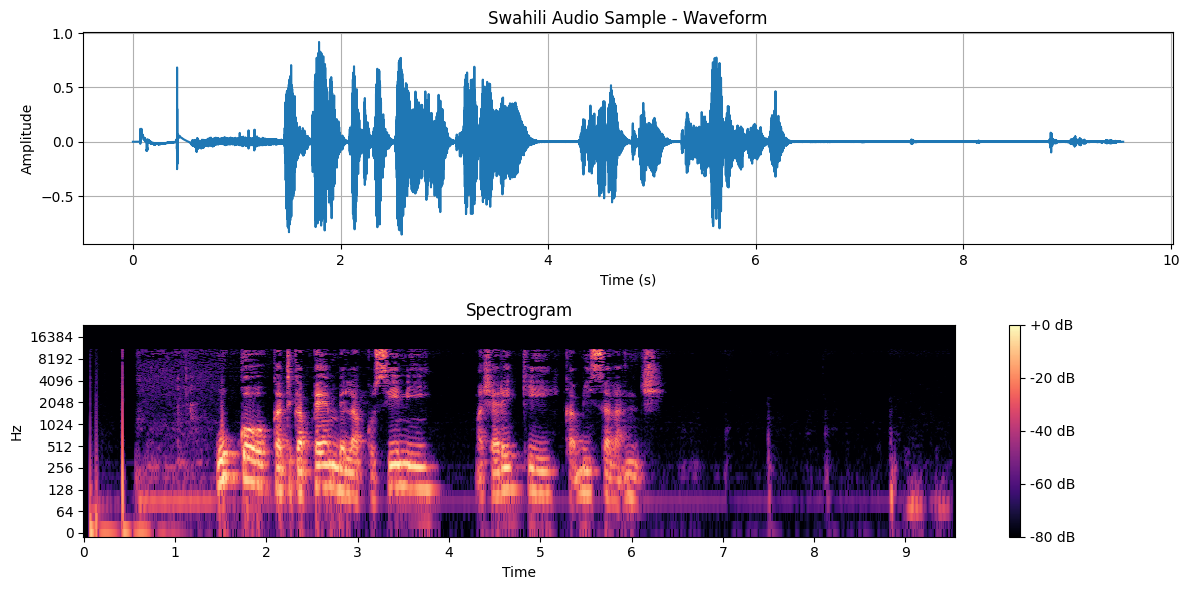

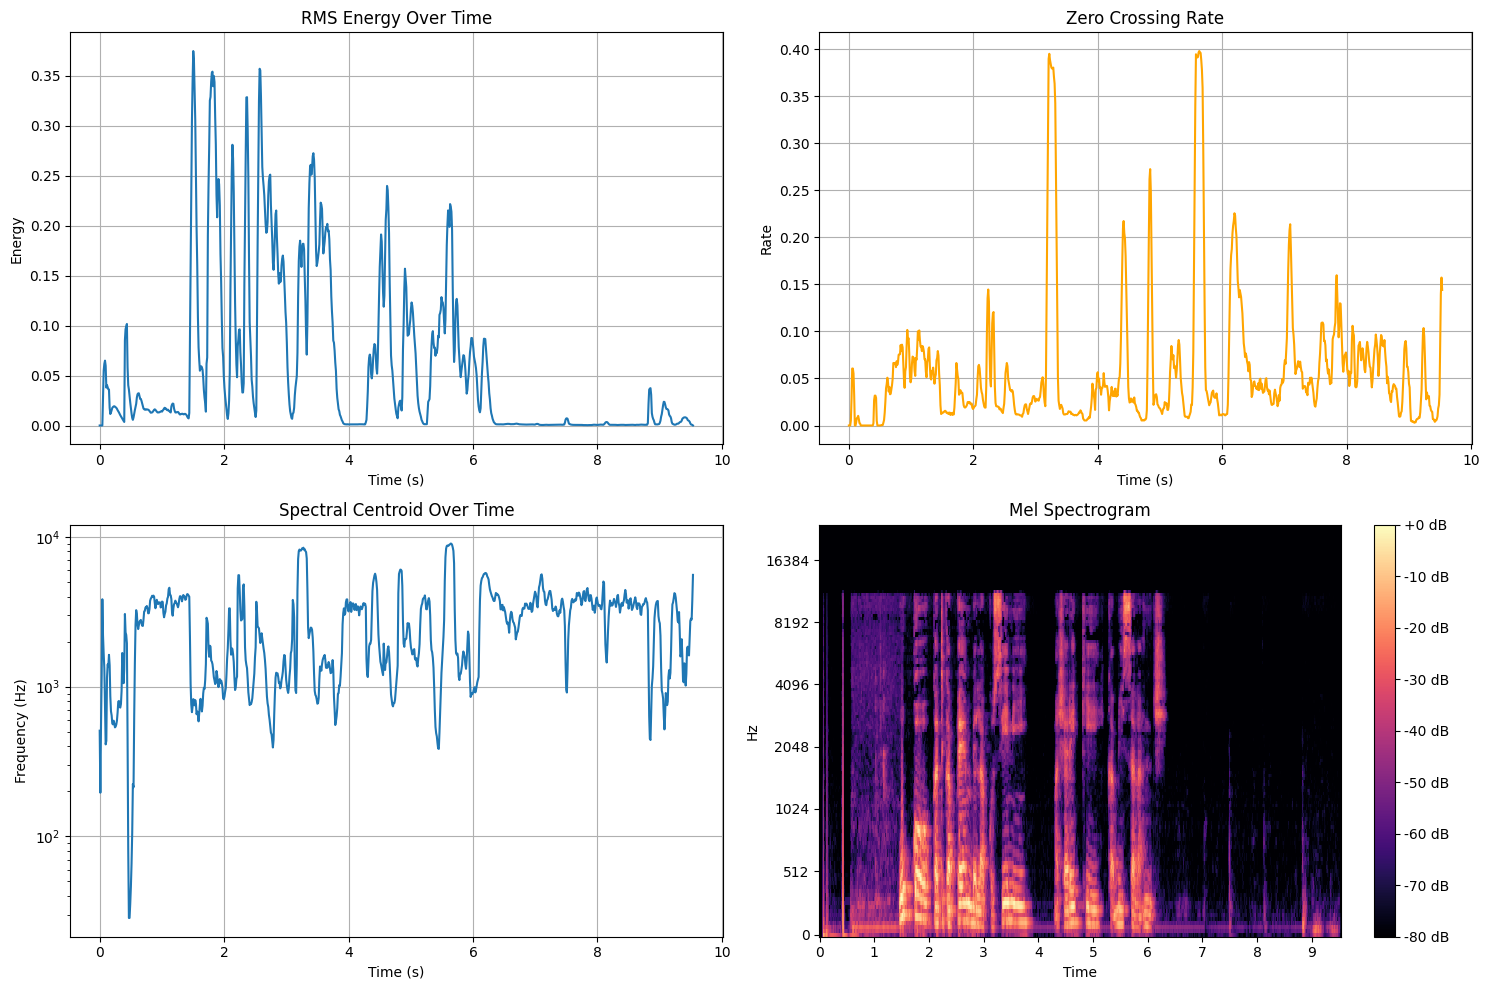

In [3]:
# Cell 3: Audio Visualization and Playback (Fixed Version)

def analyze_audio_features(audio_data, sr=16000):
    """
    Analyze and display audio features
    Args:
        audio_data: Audio array
        sr: Sampling rate
    Returns:
        dict: Dictionary containing computed features
    """
    try:
        # Initialize features dictionary
        features = {}
        
        # 1. Basic Features
        features['duration'] = len(audio_data) / sr
        features['samples'] = len(audio_data)
        
        # 2. Compute Features
        # Tempo and beats
        tempo, beats = librosa.beat.beat_track(y=audio_data, sr=sr)
        features['tempo'] = float(tempo)  # Convert to float for safe formatting
        
        # RMS Energy
        rmse = librosa.feature.rms(y=audio_data)[0]
        features['rms_mean'] = float(np.mean(rmse))
        features['rms_std'] = float(np.std(rmse))
        
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio_data)[0]
        features['zcr_mean'] = float(np.mean(zcr))
        
        # Spectral Centroid
        spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]
        features['spectral_centroid_mean'] = float(np.mean(spectral_centroids))
        
        # Print Features
        print("\nAudio Features Summary:")
        print(f"Duration: {features['duration']:.2f} seconds")
        print(f"Number of samples: {features['samples']}")
        print(f"Estimated tempo: {features['tempo']:.1f} BPM")
        print(f"Average RMS energy: {features['rms_mean']:.6f}")
        print(f"RMS energy std: {features['rms_std']:.6f}")
        print(f"Average zero crossing rate: {features['zcr_mean']:.6f}")
        print(f"Average spectral centroid: {features['spectral_centroid_mean']:.1f} Hz")
        
        # Plotting
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. RMS Energy
        times_rms = librosa.times_like(rmse, sr=sr)
        ax1.plot(times_rms, rmse)
        ax1.set_title("RMS Energy Over Time")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Energy")
        ax1.grid(True)
        
        # 2. Zero Crossing Rate
        times_zcr = librosa.times_like(zcr, sr=sr)
        ax2.plot(times_zcr, zcr, color='orange')
        ax2.set_title("Zero Crossing Rate")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Rate")
        ax2.grid(True)
        
        # 3. Spectral Centroid
        times_cent = librosa.times_like(spectral_centroids, sr=sr)
        ax3.semilogy(times_cent, spectral_centroids, label='Spectral Centroid')
        ax3.set_title("Spectral Centroid Over Time")
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Frequency (Hz)")
        ax3.grid(True)
        
        # 4. Mel Spectrogram
        mel_spect = librosa.feature.melspectrogram(y=audio_data, sr=sr)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        img = librosa.display.specshow(mel_spect_db, y_axis='mel', x_axis='time', 
                                     ax=ax4, sr=sr)
        ax4.set_title("Mel Spectrogram")
        fig.colorbar(img, ax=ax4, format='%+2.0f dB')
        
        plt.tight_layout()
        return features
        
    except Exception as e:
        print(f"Error analyzing audio features: {str(e)}")
        return None

def visualize_audio(audio_data, sr=16000, title="Waveform"):
    """
    Visualize audio data with waveform and spectrogram
    Args:
        audio_data: Audio array from dataset
        sr: Sampling rate (default: 16000 for Common Voice)
        title: Title for the plot
    """
    try:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
        
        # Plot waveform
        times = np.arange(len(audio_data)) / sr
        ax1.plot(times, audio_data)
        ax1.set_title(f"{title} - Waveform")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Amplitude")
        ax1.grid(True)
        
        # Plot spectrogram
        D = librosa.amplitude_to_db(
            np.abs(librosa.stft(audio_data, n_fft=2048, hop_length=512)),
            ref=np.max
        )
        img = librosa.display.specshow(
            D, 
            y_axis='log', 
            x_axis='time',
            sr=sr,
            hop_length=512,
            ax=ax2
        )
        ax2.set_title("Spectrogram")
        fig.colorbar(img, ax=ax2, format="%+2.0f dB")
        
        plt.tight_layout()
        
        # Return audio player
        return Audio(data=audio_data, rate=sr)
    except Exception as e:
        print(f"Error visualizing audio: {str(e)}")
        return None

def process_audio_sample(dataset, index=0):
    """
    Process and visualize a single audio sample from the dataset
    Args:
        dataset: Hugging Face streaming dataset
        index: Index of sample to process
    """
    try:
        # Get single sample
        sample = next(iter(dataset.take(index + 1)))
        
        # Extract audio data and text
        audio_data = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']
        text = sample['sentence']
        
        print("\nAudio Sample Information:")
        print(f"Text Transcription: {text}")
        
        # Visualize basic waveform and spectrogram
        audio_display = visualize_audio(
            audio_data, 
            sr=sampling_rate,
            title="Swahili Audio Sample"
        )
        
        if audio_display:
            display(audio_display)
            
        # Analyze features
        features = analyze_audio_features(audio_data, sampling_rate)
        
        return features
        
    except Exception as e:
        print(f"Error processing audio sample: {str(e)}")
        return None

# Process and visualize first audio sample
if cv_stream is not None:
    print("Processing first audio sample...")
    features = process_audio_sample(cv_stream)


In [4]:
# Cell 4: Load and Process Text Data
# Cell: Load Mozilla Common Voice Dataset (Swahili)

def load_mozilla_cv_dataset(language="sw", split="train", streaming=True):
    """
    Load Mozilla Common Voice dataset for Swahili
    Args:
        language: Language code (default: 'sw' for Swahili)
        split: Dataset split (default: 'train')
        streaming: Whether to load in streaming mode (default: True)
    Returns:
        dataset: Hugging Face dataset object
    """
    try:
        print(f"Loading Mozilla Common Voice dataset for language: {language}")
        dataset = load_dataset(
            "mozilla-foundation/common_voice_11_0",
            language,
            split=split,
            streaming=streaming
        )
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def preview_dataset(dataset, num_samples=5):
    """
    Display preview of dataset samples
    Args:
        dataset: Hugging Face dataset
        num_samples: Number of samples to display
    """
    try:
        samples = []
        print("\nFetching sample entries...")
        for item in tqdm(dataset.take(num_samples), total=num_samples):
            sample = {
                'sentence': item['sentence'],
                'path': item['path'],
                'audio_length': item['audio']['array'].shape[0] / item['audio']['sampling_rate'],
                'sampling_rate': item['audio']['sampling_rate']
            }
            samples.append(sample)
        
        # Convert to DataFrame for better display
        df = pd.DataFrame(samples)
        print("\nDataset Sample Preview:")
        print("=" * 80)
        display(df)
        
        # Print audio statistics
        print("\nAudio Statistics:")
        print(f"Average duration: {df['audio_length'].mean():.2f} seconds")
        print(f"Sampling rate: {df['sampling_rate'].iloc[0]} Hz")
        
    except Exception as e:
        print(f"Error previewing dataset: {e}")

def analyze_text_content(dataset, num_samples=1000):
    """
    Analyze text content of the dataset
    Args:
        dataset: Hugging Face dataset
        num_samples: Number of samples to analyze
    """
    try:
        print("\nAnalyzing text content...")
        sentences = []
        word_counts = []
        
        for item in tqdm(dataset.take(num_samples), total=num_samples):
            sentence = item['sentence']
            sentences.append(sentence)
            word_counts.append(len(sentence.split()))
        
        # Calculate statistics
        avg_words = sum(word_counts) / len(word_counts)
        total_words = sum(word_counts)
        unique_words = len(set(' '.join(sentences).split()))
        
        print("\nText Content Statistics:")
        print(f"Samples analyzed: {len(sentences):,}")
        print(f"Total words: {total_words:,}")
        print(f"Unique words: {unique_words:,}")
        print(f"Average words per sentence: {avg_words:.1f}")
        
        # Display sample sentences
        print("\nSample Sentences:")
        for i, sentence in enumerate(sentences[:5], 1):
            print(f"{i}. {sentence}")
            
    except Exception as e:
        print(f"Error analyzing text content: {e}")

# Main execution
print("📥 Loading Mozilla Common Voice Swahili Dataset...")
print("=" * 80)

# Load dataset
cv_dataset = load_mozilla_cv_dataset()

if cv_dataset is not None:
    print("\n✅ Dataset loaded successfully!")
    
    # Preview dataset
    print("\n📊 Generating dataset preview...")
    preview_dataset(cv_dataset)
    
    # Analyze text content
    print("\n📝 Analyzing text content...")
    analyze_text_content(cv_dataset)
    
    print("\n✨ Dataset loading and analysis complete!")
else:
    print("\n❌ Failed to load dataset. Please check your internet connection and try again.")
    
# Additional Information
print("\n📌 Note: This dataset is loaded in streaming mode to manage memory efficiently.")
print("   Use dataset.take(n) to process n samples at a time.")


📥 Loading Mozilla Common Voice Swahili Dataset...
Loading Mozilla Common Voice dataset for language: sw

✅ Dataset loaded successfully!

📊 Generating dataset preview...

Fetching sample entries...


  0%|          | 0/5 [00:00<?, ?it/s]

Reading metadata...: 26614it [00:05, 5162.99it/s]



Dataset Sample Preview:


,sentence,path,audio_length,sampling_rate
0,Uko katika pembe la kusini-mashariki kabisa la...,sw_train_0/common_voice_sw_28660554.mp3,9.540,48000
1,Ina bandari kubwa na ni kitovu cha biashara ya...,sw_train_0/common_voice_sw_28660555.mp3,6.840,48000
2,Ndiyo maana upatikanaji wake wakati mwingine i...,sw_train_0/common_voice_sw_28660556.mp3,6.876,48000
3,Nyati wa msitu huwa nusu ya kiwango hicho.,sw_train_0/common_voice_sw_28660557.mp3,6.588,48000
4,Tangu zama za mawe miamba ilitumiwa na binadam...,sw_train_0/common_voice_sw_28660558.mp3,7.380,48000



Audio Statistics:
Average duration: 7.44 seconds
Sampling rate: 48000 Hz

📝 Analyzing text content...

Analyzing text content...


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading metadata...: 26614it [00:05, 4439.16it/s]



Text Content Statistics:
Samples analyzed: 1,000
Total words: 9,371
Unique words: 3,596
Average words per sentence: 9.4

Sample Sentences:
1. Uko katika pembe la kusini-mashariki kabisa la nchi.
2. Ina bandari kubwa na ni kitovu cha biashara ya nje.
3. Ndiyo maana upatikanaji wake wakati mwingine inakuwa vigumu kiasi.
4. Nyati wa msitu huwa nusu ya kiwango hicho.
5. Tangu zama za mawe miamba ilitumiwa na binadamu kama zana.

✨ Dataset loading and analysis complete!

📌 Note: This dataset is loaded in streaming mode to manage memory efficiently.
   Use dataset.take(n) to process n samples at a time.


Generating comprehensive dataset analysis...

1. Analyzing dataset...
Analyzing dataset statistics (sampling 500 entries)...


  0%|          | 0/500 [00:00<?, ?it/s]

Reading metadata...: 26614it [00:07, 3690.27it/s]



2. Generating detailed summary...

=== Mozilla Common Voice Swahili Dataset Summary ===

📊 Audio Statistics:
--------------------------------------------------
Total samples analyzed: 500
Total duration: 3136.72 seconds
Average duration: 6.27 seconds
Std dev duration: 1.44 seconds
Min duration: 2.70 seconds
Max duration: 10.08 seconds
Sampling rate: 48000 Hz

📝 Text Statistics:
--------------------------------------------------
Total characters: 29,676
Total words: 4,696
Unique words: 2,206
Average words per sentence: 9.4

📈 Top 10 Most Frequent Words:
--------------------------------------------------
ya: 272
na: 219
wa: 169
kwa: 81
katika: 62
la: 61
ni: 60
za: 46
kama: 30
cha: 28

3. Creating visualizations...

✅ Dataset report generated successfully!


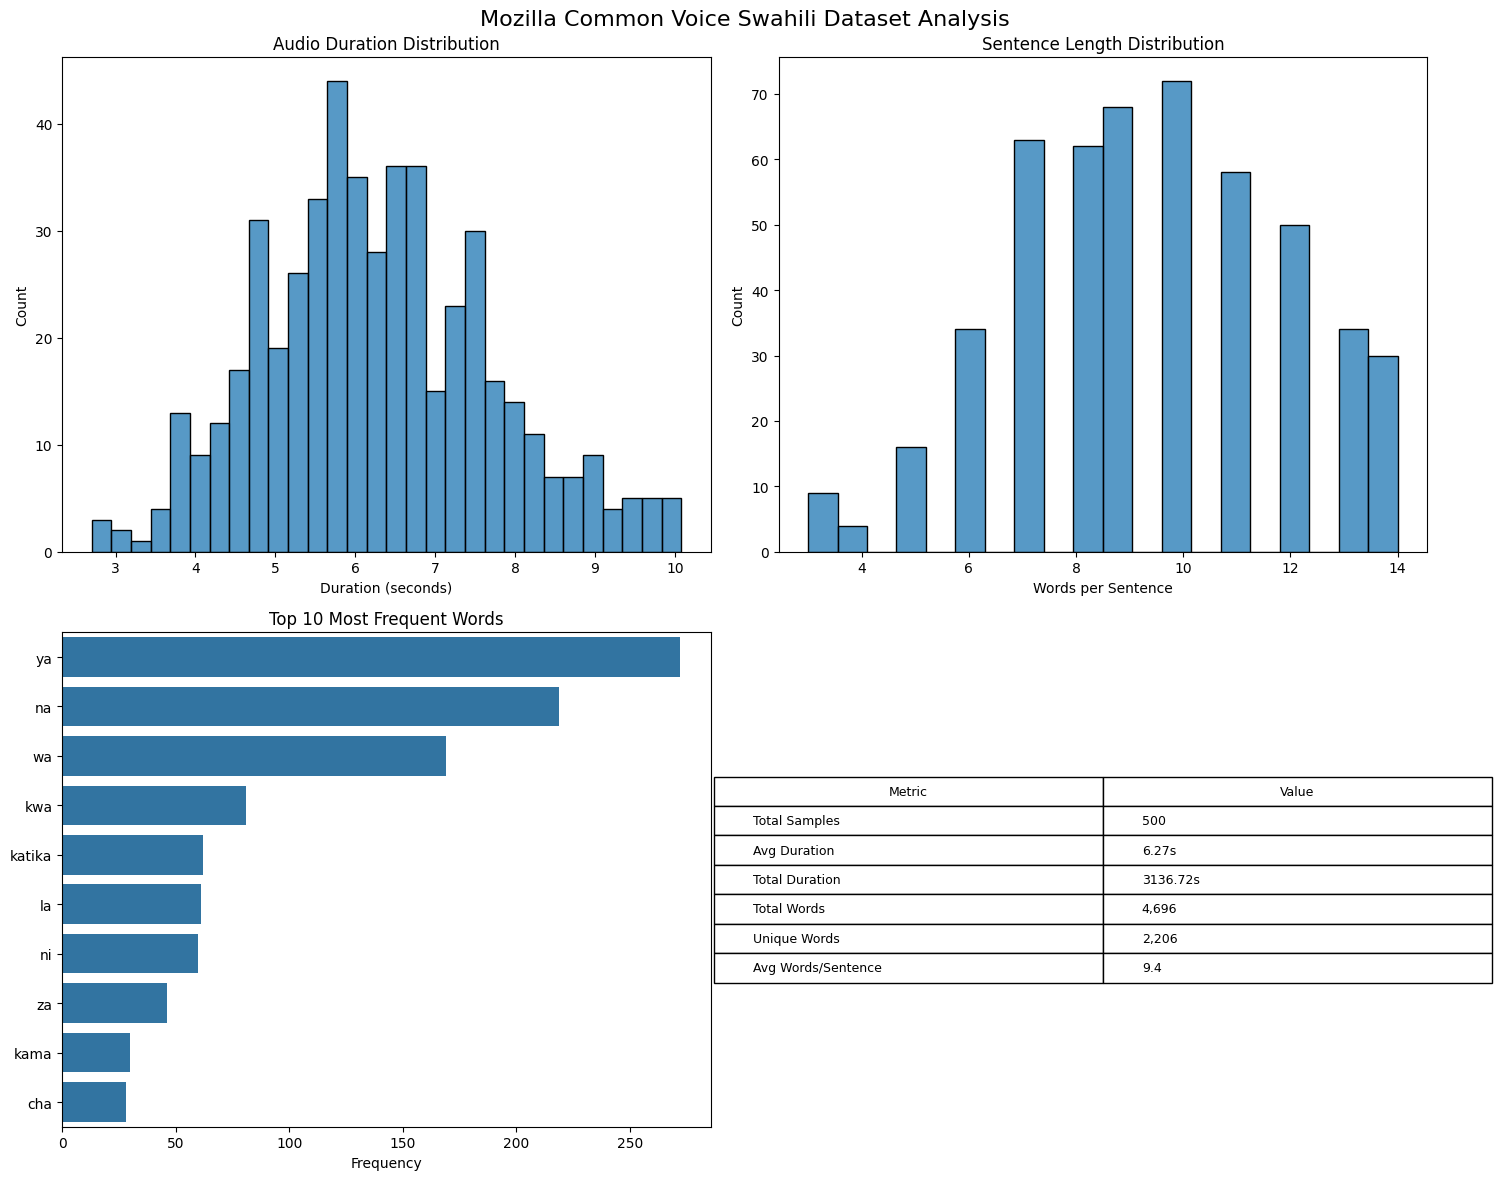

In [5]:
# Cell 5: Dataset Summary Statistics (Audio-Only Version)
def analyze_audio_dataset(dataset, num_samples=1000):
    """
    Analyze audio and text statistics from the Mozilla Common Voice dataset
    Args:
        dataset: Hugging Face streaming dataset
        num_samples: Number of samples to analyze
    Returns:
        dict: Dataset statistics
    """
    stats = {
        'audio': {
            'durations': [],
            'sampling_rates': [],
            'total_samples': 0
        },
        'text': {
            'total_chars': 0,
            'total_words': 0,
            'word_frequencies': Counter(),
            'char_frequencies': Counter(),
            'sentence_lengths': []
        }
    }
    
    print(f"Analyzing dataset statistics (sampling {num_samples} entries)...")
    for item in tqdm(dataset.take(num_samples), total=num_samples):
        # Audio statistics
        duration = len(item['audio']['array']) / item['audio']['sampling_rate']
        stats['audio']['durations'].append(duration)
        stats['audio']['sampling_rates'].append(item['audio']['sampling_rate'])
        stats['audio']['total_samples'] += 1
        
        # Text statistics
        text = item['sentence']
        words = text.split()
        stats['text']['total_chars'] += len(text)
        stats['text']['total_words'] += len(words)
        stats['text']['word_frequencies'].update(words)
        stats['text']['char_frequencies'].update(text)
        stats['text']['sentence_lengths'].append(len(words))
    
    return stats

def visualize_dataset_statistics(stats):
    """
    Create visualizations for dataset statistics
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Mozilla Common Voice Swahili Dataset Analysis', fontsize=16)
    
    # 1. Audio Duration Distribution
    sns.histplot(stats['audio']['durations'], bins=30, ax=ax1)
    ax1.set_title('Audio Duration Distribution')
    ax1.set_xlabel('Duration (seconds)')
    ax1.set_ylabel('Count')
    
    # 2. Sentence Length Distribution
    sns.histplot(stats['text']['sentence_lengths'], bins=20, ax=ax2)
    ax2.set_title('Sentence Length Distribution')
    ax2.set_xlabel('Words per Sentence')
    ax2.set_ylabel('Count')
    
    # 3. Top Words
    words, counts = zip(*stats['text']['word_frequencies'].most_common(10))
    sns.barplot(x=list(counts), y=list(words), ax=ax3)
    ax3.set_title('Top 10 Most Frequent Words')
    ax3.set_xlabel('Frequency')
    
    # 4. Summary Statistics Table
    ax4.axis('off')
    summary_data = [
        ['Total Samples', f"{stats['audio']['total_samples']:,}"],
        ['Avg Duration', f"{np.mean(stats['audio']['durations']):.2f}s"],
        ['Total Duration', f"{sum(stats['audio']['durations']):.2f}s"],
        ['Total Words', f"{stats['text']['total_words']:,}"],
        ['Unique Words', f"{len(stats['text']['word_frequencies']):,}"],
        ['Avg Words/Sentence', f"{np.mean(stats['text']['sentence_lengths']):.1f}"]
    ]
    table = ax4.table(cellText=summary_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()
    return fig

def print_detailed_summary(stats):
    """
    Print detailed summary statistics
    """
    print("\n=== Mozilla Common Voice Swahili Dataset Summary ===")
    
    # Audio Statistics
    print("\n📊 Audio Statistics:")
    print("-" * 50)
    print(f"Total samples analyzed: {stats['audio']['total_samples']:,}")
    print(f"Total duration: {sum(stats['audio']['durations']):.2f} seconds")
    print(f"Average duration: {np.mean(stats['audio']['durations']):.2f} seconds")
    print(f"Std dev duration: {np.std(stats['audio']['durations']):.2f} seconds")
    print(f"Min duration: {min(stats['audio']['durations']):.2f} seconds")
    print(f"Max duration: {max(stats['audio']['durations']):.2f} seconds")
    print(f"Sampling rate: {stats['audio']['sampling_rates'][0]} Hz")
    
    # Text Statistics
    print("\n📝 Text Statistics:")
    print("-" * 50)
    print(f"Total characters: {stats['text']['total_chars']:,}")
    print(f"Total words: {stats['text']['total_words']:,}")
    print(f"Unique words: {len(stats['text']['word_frequencies']):,}")
    print(f"Average words per sentence: {np.mean(stats['text']['sentence_lengths']):.1f}")
    
    # Most Common Words
    print("\n📈 Top 10 Most Frequent Words:")
    print("-" * 50)
    for word, count in stats['text']['word_frequencies'].most_common(10):
        print(f"{word}: {count:,}")

def generate_dataset_report(dataset, num_samples=1000):
    """
    Generate comprehensive dataset report
    Args:
        dataset: Hugging Face streaming dataset
        num_samples: Number of samples to analyze
    """
    try:
        # Analyze statistics
        print("\n1. Analyzing dataset...")
        stats = analyze_audio_dataset(dataset, num_samples)
        
        # Print detailed summary
        print("\n2. Generating detailed summary...")
        print_detailed_summary(stats)
        
        # Create visualizations
        print("\n3. Creating visualizations...")
        fig = visualize_dataset_statistics(stats)
        
        print("\n✅ Dataset report generated successfully!")
        return fig
        
    except Exception as e:
        print(f"\n❌ Error generating dataset report: {e}")
        return None

# Generate dataset report
if cv_dataset is not None:
    print("Generating comprehensive dataset analysis...")
    fig = generate_dataset_report(cv_dataset, num_samples=500)  # Analyze 500 samples
    if fig:
        plt.show()
else:
    print("❌ Cannot generate summary: Dataset not loaded")


In [ ]:
# Cell: Load and Process Swahili Text Data
import os
from pathlib import Path
import PyPDF2
import chardet
from tqdm.auto import tqdm

def detect_file_encoding(file_path):
    """
    Detect the encoding of a text file
    Args:
        file_path: Path to the text file
    Returns:
        str: Detected encoding
    """
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def read_pdf(file_path):
    """
    Read text content from PDF file
    Args:
        file_path: Path to PDF file
    Returns:
        str: Extracted text content
    """
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text() + "\n"
        return text.strip()
    except Exception as e:
        print(f"Error reading PDF {file_path}: {e}")
        return ""

def read_txt(file_path):
    """
    Read text content from TXT file with encoding detection
    Args:
        file_path: Path to TXT file
    Returns:
        str: File content
    """
    try:
        encoding = detect_file_encoding(file_path)
        with open(file_path, 'r', encoding=encoding) as file:
            return file.read().strip()
    except UnicodeDecodeError:
        # Fallback encodings
        for encoding in ['utf-8', 'latin-1', 'cp1252']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    return file.read().strip()
            except UnicodeDecodeError:
                continue
        print(f"Error: Could not decode {file_path} with any encoding")
        return ""
    except Exception as e:
        print(f"Error reading TXT {file_path}: {e}")
        return ""

def load_text_data(data_folder):
    """
    Load text content from PDF and TXT files
    Args:
        data_folder: Path to folder containing text files
    Returns:
        dict: Dictionary with filename as key and content as value
    """
    texts = {}
    data_path = Path(data_folder)
    
    if not data_path.exists():
        print(f"Error: Directory {data_folder} not found")
        return texts
    
    print(f"Loading text files from: {data_folder}")
    files = list(data_path.glob("*.pdf")) + list(data_path.glob("*.txt"))
    
    for file_path in tqdm(files, desc="Processing files"):
        try:
            if file_path.suffix.lower() == '.pdf':
                content = read_pdf(file_path)
            else:  # .txt
                content = read_txt(file_path)
                
            if content:  # Only add if content was successfully extracted
                texts[file_path.name] = content
                
        except Exception as e:
            print(f"Error processing {file_path.name}: {e}")
            continue
    
    return texts

def display_text_preview(texts, preview_length=500):
    """
    Display preview of loaded texts
    Args:
        texts: Dictionary of filename-content pairs
        preview_length: Number of characters to preview
    """
    if not texts:
        print("No text files were loaded successfully.")
        return
    
    print(f"\n📚 Successfully loaded {len(texts)} files:")
    print("=" * 80)
    
    for filename, content in texts.items():
        print(f"\n📖 File: {filename}")
        print("-" * 40)
        print(f"Total length: {len(content):,} characters")
        print(f"Preview of first {preview_length} characters:")
        print("-" * 40)
        print(content[:preview_length] + "...")
        print("\n")

def analyze_text_content(texts):
    """
    Analyze content of loaded texts
    Args:
        texts: Dictionary of filename-content pairs
    """
    if not texts:
        return
    
    print("\n📊 Text Analysis:")
    print("=" * 80)
    
    total_chars = 0
    total_words = 0
    total_lines = 0
    word_frequencies = Counter()
    
    for filename, content in texts.items():
        chars = len(content)
        words = len(content.split())
        lines = len(content.splitlines())
        
        total_chars += chars
        total_words += words
        total_lines += lines
        
        word_frequencies.update(content.split())
        
        print(f"\nFile: {filename}")
        print(f"Characters: {chars:,}")
        print(f"Words: {words:,}")
        print(f"Lines: {lines:,}")
    
    print("\n📈 Overall Statistics:")
    print("-" * 40)
    print(f"Total Characters: {total_chars:,}")
    print(f"Total Words: {total_words:,}")
    print(f"Total Lines: {total_lines:,}")
    print(f"Unique Words: {len(word_frequencies):,}")
    
    print("\n🔤 Most Common Words:")
    print("-" * 40)
    for word, count in word_frequencies.most_common(10):
        print(f"{word}: {count:,}")

# Main execution
print("📥 Loading Swahili Text Data...")
swahili_texts = load_text_data(r"E:\Sema\data\swahili_text")

# Display preview and analysis
display_text_preview(swahili_texts)
analyze_text_content(swahili_texts)

📥 Loading Swahili Text Data...
Loading text files from: E:\Sema\data\swahili_text


Processing files:   0%|          | 0/11 [00:00<?, ?it/s]


📚 Successfully loaded 11 files:

📖 File: 100 DRAFT 2.pdf
----------------------------------------
Total length: 23,756 characters
Preview of first 500 characters:
----------------------------------------
100
By
SABURI ISMAIL SEIF
2022. WUNDERBASE saburiseifismail@gmail.com
wunderbasetv@gmail.com
FADE IN:
1 EXT. MAJANI MAREFU - USIKU 1
Giza limetawala kila kona. Sauti ya upepo uliotulia
inasikika, majani yakipelekwa na huo. Anapita msichana,
hatumuoni sura, akiwa amevalia gauni, anakimbia.
Tunasikia sauti yake akihema kwa shida. Anajaribu
kugeuka,anamuona mwanaume akiwa anamfata. Mwanaume kavalia
nguo nyeusi.
Msichana anaanguka, mwanaume anamfikia na kukaa juu yake.
Msichana anahangaika kujiokoa ...



📖 File: 5DAYS FAMILY Script.pdf
----------------------------------------
Total length: 7,916 characters
Preview of first 500 characters:
----------------------------------------
5days
 
Family
 
by
 
Gervas
 
Mahimbi
 
Gervas
 
Mahimbi
 
1744,
 
Iringa
 
+255
 
716
 
245525
 
gerrymahimb

In [7]:
# Cell: Clear Memory
import gc
def clear_memory():
    """
    Clear memory by removing large objects and cleaning cache
    Returns:
        dict: Memory usage statistics before and after cleaning
    """
    import gc
    import psutil
    import sys
    
    def get_memory_usage():
        """Get current memory usage in MB"""
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024

    try:
        # Get initial memory usage
        initial_memory = get_memory_usage()
        
        print("🧹 Cleaning memory...")
        
        # Clear large variables that might be in your notebook
        large_variables = [
            'cv_dataset', 'cv_train', 'audio_display', 
            'swahili_texts', 'text_data', 'fig', 
            'stats', 'samples', 'model', 'tokenizer',
            'audio_stats', 'text_stats', 'dataset',
            'texts', 'word_frequencies', 'content'
        ]
        
        # Clear global variables
        for var in large_variables:
            if var in globals():
                globals().pop(var)
                print(f"✓ Cleared {var}")
        
        # Clear matplotlib figures
        plt.close('all')
        print("✓ Cleared matplotlib figures")
        
        # Clear pandas cache
        try:
            pd.DataFrame._metadata.clear()
            print("✓ Cleared pandas cache")
        except:
            pass
        
        # Clear torch cuda cache if available
        try:
            import torch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print("✓ Cleared CUDA cache")
        except:
            pass
        
        # Run garbage collector
        collected = gc.collect()
        print(f"✓ Ran garbage collector (collected {collected} objects)")
        
        # Get final memory usage
        final_memory = get_memory_usage()
        memory_freed = initial_memory - final_memory
        
        print("\n📊 Memory Usage Statistics:")
        print(f"Initial memory usage: {initial_memory:.1f} MB")
        print(f"Final memory usage: {final_memory:.1f} MB")
        print(f"Memory freed: {memory_freed:.1f} MB")
        
        return {
            'initial_memory': initial_memory,
            'final_memory': final_memory,
            'memory_freed': memory_freed
        }
        
    except Exception as e:
        print(f"❌ Error during memory cleanup: {e}")
        return None

# Execute memory cleanup
if __name__ == "__main__":
    print("\n🔄 Starting memory cleanup process...")
    stats = clear_memory()
    print("\n✅ Memory cleanup complete!")
    
    # System memory info
    try:
        import psutil
        vm = psutil.virtual_memory()
        print("\n💻 System Memory Status:")
        print(f"Total: {vm.total / 1024 / 1024 / 1024:.1f} GB")
        print(f"Available: {vm.available / 1024 / 1024 / 1024:.1f} GB")
        print(f"Used: {vm.used / 1024 / 1024 / 1024:.1f} GB")
        print(f"Percentage: {vm.percent}%")
        
        # CPU usage
        cpu_percent = psutil.cpu_percent(interval=1)
        print(f"\n🔄 CPU Usage: {cpu_percent}%")
    except:
        pass

# Optional: Add this line to force immediate garbage collection
gc.collect()



🔄 Starting memory cleanup process...
🧹 Cleaning memory...
✓ Cleared cv_dataset
✓ Cleared swahili_texts
✓ Cleared fig
✓ Cleared matplotlib figures
✓ Cleared pandas cache
✓ Ran garbage collector (collected 17189 objects)

📊 Memory Usage Statistics:
Initial memory usage: 444.2 MB
Final memory usage: 437.3 MB
Memory freed: 6.9 MB

✅ Memory cleanup complete!

💻 System Memory Status:
Total: 31.2 GB
Available: 14.7 GB
Used: 16.5 GB
Percentage: 52.9%

🔄 CPU Usage: 9.2%


0

In [9]:
# !pip install torch torchvision torchaudio numpy matplotlib seaborn librosa datasets evaluate transformers nltk rouge-score tqdm hf_xet jiwer gradio sacremoses

In [1]:
# Standard Libraries

import os
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Numerical & Audio Processing
import numpy as np
import torch
import librosa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets & Evaluation
from datasets import load_dataset, Audio
import evaluate
from tqdm import tqdm

# Transformers
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    TrainingArguments,
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    Trainer
)

# Deployent
import gradio as gr

# NLP Metrics
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [19]:
# Cell: Load and split Swahili dataset for training

def load_swahili_dataset():
    """Load and split Swahili dataset from Common Voice"""
    # For better memory management, use force_redownload
    original_dataset = load_dataset(
        "mozilla-foundation/common_voice_11_0",
        "sw",
        split="train+validation",
        download_mode="force_redownload",
        trust_remote_code=True  # Add this parameter
    )
    print(f"📦 Original full train+validation dataset size: {len(original_dataset)}")
    
    # Rest of your function remains the same


    # Load reduced dataset: first 5% of the original
    reduced_dataset = original_dataset.select(range(int(len(original_dataset) * 0.05)))
    print(f"🔍 Reduced dataset size (5% of original): {len(reduced_dataset)}")

    # Split reduced dataset: 80% train, 20% temp (test+validation)
    train_testvalid = reduced_dataset.train_test_split(test_size=0.2, seed=42)
    print(f"🟢 Train split size (80% of reduced): {len(train_testvalid['train'])}")
    print(f"🟡 Temp split size (20% of reduced): {len(train_testvalid['test'])}")

    # Further split temp into validation (50%) and test (50%)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)
    print(f"🔵 Validation split size (10% of reduced): {len(test_valid['train'])}")
    print(f"🔴 Test split size (10% of reduced): {len(test_valid['test'])}")
    
    return {
        'train': train_testvalid['train'],
        'validation': test_valid['train'],
        'test': test_valid['test']
    }

# Run the function to load and split the dataset
swahili_splits = load_swahili_dataset()


Reading metadata...: 26614it [00:00, 216613.48it/s]es/s]
Generating train split: 26614 examples [00:05, 4481.72 examples/s]
Reading metadata...: 10233it [00:00, 264308.80it/s]xamples/s]
Generating validation split: 10233 examples [00:01, 5143.78 examples/s]
Reading metadata...: 10238it [00:00, 256591.06it/s]s/s]
Generating test split: 10238 examples [00:01, 5330.40 examples/s]
Reading metadata...: 240109it [00:01, 220812.33it/s]s/s]
Generating other split: 240109 examples [00:46, 5147.20 examples/s]
Reading metadata...: 47470it [00:00, 244535.64it/s]examples/s]
Generating invalidated split: 47470 examples [00:09, 5207.66 examples/s]

📦 Original full train+validation dataset size: 36847
🔍 Reduced dataset size (5% of original): 1842
🟢 Train split size (80% of reduced): 1473
🟡 Temp split size (20% of reduced): 369
🔵 Validation split size (10% of reduced): 184
🔴 Test split size (10% of reduced): 185
